# Preliminary Analysis 

In [213]:
# In this notebook, we will load the data and perform preliminary analysis

In [214]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [215]:
# Read the files 
transactions_sample = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

# Pre Process the tags column in tbl_merchants

In [216]:
merchants = merchants_tbl.toPandas()

In [217]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
import string

# This is used to for NLP of the description
def text_process(text):
    stemmer = WordNetLemmatizer()
    # Remove all punctuation and numbers 
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    # Remove all stopwords
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    # lemmatize and output
    return ' '.join([stemmer.lemmatize(word) for word in nopunc])

In [218]:
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description and pre process
    descr = str(string_cut[0].strip('(('))
    #descr = re.sub(r'[-|,|_|:]', ' ', descr)
    #descr = re.sub(r' +', ' ', descr)
    #descr = descr.split()
    #descr = ' '.join([word for word in descr if word not in stop_words])
    new_string.append(text_process(descr))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [219]:
import pandas as pd
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)

In [220]:
all_words = list(set(' '.join(set([' '.join(merchant_tbl['Description'])])).split()))

In [221]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconvert = TfidfVectorizer().fit(all_words)

In [222]:
desc_transformed=tfidfconvert.transform(merchant_tbl['Description'])

In [223]:
# Need to work out how many unique labels there are
max_cluster = len(set(merchant_tbl['Description']))

In [224]:
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=max_cluster, init='k-means++', n_init=100)
modelkmeans.fit(desc_transformed)

KMeans(n_clusters=25, n_init=100)

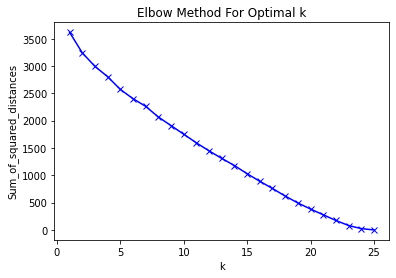

In [227]:
#checking for optimal number of clusters

from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,max_cluster + 1)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(desc_transformed)
    Sum_of_squared_distances.append(km.inertia_)


import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()